In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [1]:
import numpy as np 
from tqdm.notebook import tqdm 
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [25]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import torch.optim.lr_scheduler as lr_scheduler

# Load

In [3]:
transforms_simple = T.Compose([
    T.ToTensor(), 
])

train_folder = ImageFolder('tiny-imagenet-200/train', transform=transforms_simple)
val_folder = ImageFolder('tiny-imagenet-200/val', transform=transforms_simple)
test_folder = ImageFolder('tiny-imagenet-200/test', transform=transforms_simple)


train_loader = torch.utils.data.DataLoader(
    train_folder,
    batch_size=128,
    shuffle=True,
    num_workers=16
)

val_loader = torch.utils.data.DataLoader(
    val_folder,
    batch_size=128,
    shuffle=True,
    num_workers=16
)

test_loader = torch.utils.data.DataLoader(
    test_folder,
    batch_size=128,
    shuffle=True,
    num_workers=16
)

In [4]:
mean = torch.zeros(3, dtype=float)
mean_sq = torch.zeros(3, dtype=float)
n = len(train_loader)

for x, _ in train_loader:
    mean += torch.mean(x, dim=(0, 2, 3))
    mean_sq += torch.mean(x ** 2, dim=(0, 2, 3))

mean /= n
mean_sq /= n
std = torch.sqrt(mean_sq - mean ** 2)

In [5]:
mean

tensor([0.4802, 0.4481, 0.3975], dtype=torch.float64)

In [6]:
std

tensor([0.2770, 0.2690, 0.2821], dtype=torch.float64)

In [7]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    # mean, std ->
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]

    renormalized_tensor = mean + std * tensor
    image = renormalized_tensor.permute(1, 2, 0).detach().cpu().numpy()

    return image

In [8]:
num_classes = len(train_folder.class_to_idx)

# Model

In [9]:
model = torchvision.models.GoogLeNet()

/home/denis/miniconda3/lib/python3.10/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [12]:
model.conv1 = nn.Conv2d(3, 192, kernel_size=7, stride=1, padding=0)
model.conv2 = nn.Identity()
model.conv3 = nn.Identity()
model.maxpool2 = nn.Identity()

# Wandb

# Train

In [38]:
import wandb

config = {
    "learning_rate": 1e-3,
    "weight_decay": 0.05,
    "batch_size": 128,
    "num_epochs": 10,
    "optimizer": torch.optim.AdamW,
}

wandb.init(
    # set the wandb project where this run will be logged
    project="hw2",
    name="HooLeNetTorch LR sheduler",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,▅▆▆▅▆▁▂█▄▂▃▂▂▁▄▄▂▂▄▁▄▃▅▅▂█▇▃▅▄▂▇▆▇▃▃▃▄▃▂
loss,1.72816


In [39]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    # mean, std ->
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]

    renormalized_tensor = mean + std * tensor
    image = renormalized_tensor.permute(1, 2, 0).detach().cpu().numpy()

    return image

In [40]:
def save_checkpoint(model, filename):

    with open(filename, "wb") as fp:
        torch.save(model.state_dict(), fp)


def load_checkpoint(model, filename):

    with open(filename, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(state_dict)

In [41]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, sheduler, epoch, device):
    # v NOTE THIS v
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()
    # ^ NOTE THIS ^

    model = model.to(device)

    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs, ys_true = batch

        # ys_pred = model(xs.to(device))
        # loss = loss_fn(ys_pred, ys_true.to(device))

        ys_true = ys_true.to(device)

        output = model(xs.to(device))

        if stage == "train":
            o1 = output.aux_logits1
            o2 = output.aux_logits2
            o3 = output.logits

            loss1 = loss_fn(o1, ys_true)
            loss2 = loss_fn(o2, ys_true)
            loss3 = loss_fn(o3, ys_true)

            loss = 0.1 * loss1 + 0.3 * loss2 + 0.5 * loss3

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            wandb.log({"lr": sheduler.get_last_lr(), "loss": loss3})

            losses.append(loss3.detach().cpu().item())

        else:
            loss = loss_fn(output, ys_true)

            losses.append(loss.detach().cpu().item())
    
    if stage == "train":
        sheduler.step()

        
    return np.mean(losses)

In [42]:
def run_experiment(
    model, dataloader_train, dataloader_val, 
    loss_fn, optimizer, sheduler, num_epochs, 
    device, output_dir, start_epoch=0
):
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    os.makedirs(output_dir, exist_ok=True)

    for epoch in range(start_epoch, start_epoch + num_epochs):
        train_loss = run_epoch("train", model, dataloader_train, loss_fn, optimizer, sheduler, epoch, device)
        train_losses.append(train_loss)

        val_loss = run_epoch("val", model, dataloader_val, loss_fn, optimizer, sheduler, epoch, device)
        val_losses.append(val_loss)

        wandb.log({"epoch_loss_train": train_loss, "epoch_loss_val": val_loss, "epoch": epoch})

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, output_fn)
            print(f"New checkpoint saved to {output_fn}\n")

            best_val_loss_fn = output_fn

    print(f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model


In [43]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [44]:
transforms_simple = T.Compose([
    T.ToTensor(), 
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=15),
    T.Normalize(mean, std) 
])

train_folder = ImageFolder('tiny-imagenet-200/train', transform=transforms_simple)
val_folder = ImageFolder('tiny-imagenet-200/val', transform=transforms_simple)
test_folder = ImageFolder('tiny-imagenet-200/test', transform=transforms_simple)


train_loader = torch.utils.data.DataLoader(
    train_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=16,
)

val_loader = torch.utils.data.DataLoader(
    val_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=16
)

test_loader = torch.utils.data.DataLoader(
    test_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=16
)

In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = config["optimizer"](
    model.parameters(), 
    lr=config["learning_rate"], 
    weight_decay=config["weight_decay"]
)

sheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [46]:
load_checkpoint(model, 'checkpoints_HooLeNetTorch/epoch=21_valloss=2.232.pth.tar')

In [47]:
train_losses_baseline, val_losses_baseline, best_val_loss_baseline, cnn_baseline = run_experiment(
    model,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    sheduler,
    config["num_epochs"],
    device,
    "checkpoints_HooLeNetTorchSheduler",
)

epoch: 000 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 000 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorchSheduler/epoch=00_valloss=1.946.pth.tar



epoch: 001 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 001 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorchSheduler/epoch=01_valloss=1.922.pth.tar



epoch: 002 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 002 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 003 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 003 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorchSheduler/epoch=03_valloss=1.904.pth.tar



epoch: 004 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 004 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 005 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 005 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorchSheduler/epoch=05_valloss=1.781.pth.tar



epoch: 006 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 006 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 007 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 007 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 008 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 008 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 009 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 009 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

Best val_loss = 1.781 reached at epoch 5


In [48]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(12, 5))
    plt.title(title)
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True)
    plt.legend()
    plt.show()

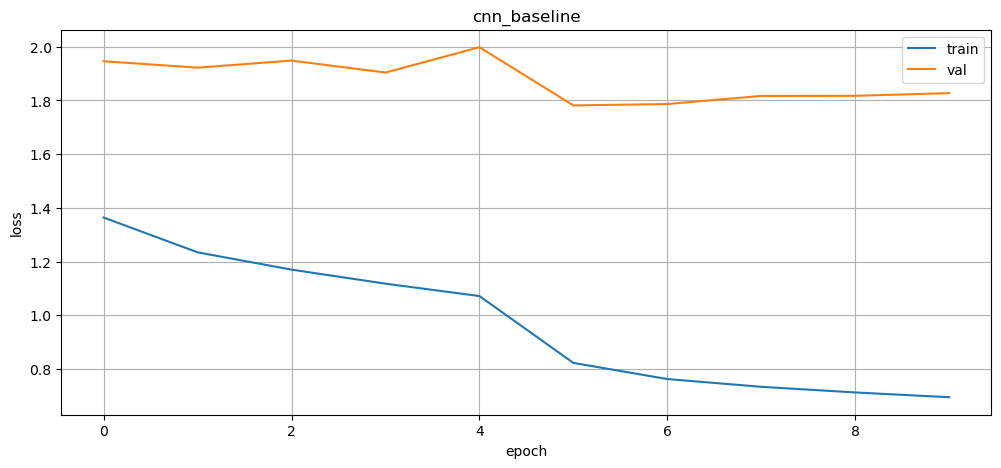

In [49]:
plot_losses(train_losses_baseline, val_losses_baseline, title="cnn_baseline")

In [50]:
def collect_predictions(model, dataloader, device):
    model.eval()
    model = model.to(device)
    torch.set_grad_enabled(False)

    labels_all = []
    probs_all = []
    preds_all = []
    for batch in tqdm(dataloader, total=len(dataloader)):
        images, labels = batch

        logits = model(images.to(device)).cpu()
        probs = logits.softmax(dim=1)
        max_prob, max_prob_index = torch.max(probs, dim=1)

        labels_all.extend(labels.numpy().tolist())
        probs_all.extend(max_prob.numpy().tolist())
        preds_all.extend(max_prob_index.numpy().tolist())

    return labels_all, probs_all, preds_all

In [51]:
train_labels, train_probs, train_preds = collect_predictions(cnn_baseline, train_loader, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

  0%|          | 0/782 [00:00<?, ?it/s]

0.83177

In [52]:
test_labels, test_probs, test_preds = collect_predictions(cnn_baseline, test_loader, device)

accuracy_train = accuracy_score(test_labels, test_preds)
accuracy_train

  0%|          | 0/79 [00:00<?, ?it/s]

0.0049

In [53]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▂▃▃▄▅▆▆▇█
epoch_loss_train,█▇▆▅▅▂▂▁▁▁
epoch_loss_val,▆▆▆▅█▁▁▂▂▂
loss,█▆▅▇▆█▆▇▆▇▇▆▅█▆▇▇▄▇▅▅▄▄▃▃▄▄▄▃▁▃▄▃▃▂▅▂▃▂▃
epoch,9
epoch_loss_train,0.69491
epoch_loss_val,1.82711
loss,1.18579
